In [125]:
%reset -f
import time
t_start = time.time()

In [126]:
import sys

HOME_PATH = "../../"
sys.path.insert(0, HOME_PATH + "qe")

import os
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import shap
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sn
import my_cmaps
from numba import njit

In [127]:
# some constant
GEV = 1e-3
WORKERS = 64
RNG = np.random.default_rng(2024)
HOME_PATH = "../../"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [128]:
# TODO

import get_data as gd


SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 76

['/root/data/truth/background/CGLMP.npz', '/root/data/truth/background/Higgs.npz', '/root/data/truth/background/LeadLepton.npz', '/root/data/truth/background/LeptonM.npz', '/root/data/truth/background/LeptonP.npz', '/root/data/truth/background/LmNu.npz', '/root/data/truth/background/LpNu.npz', '/root/data/truth/background/MET.npz', '/root/data/truth/background/WmBoson.npz', '/root/data/truth/background/WpBoson.npz', '/root/data/truth/background/diLepton.npz', '/root/data/truth/background/subLeadLepton.npz', '/root/data/truth/background/xi_xyz.npz']



In [192]:
## Global variables

GEV = 1e3

print(f"RAW    : {len(data.LeadLep['pt'])}")
cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
print(f"pt_lead: {cut_pre_pt_lead.sum()}")
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
print(f"pt_sub : {cut_pre_pt_sub.sum()}")
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
print(f"dilep_m: {cut_pre_dilep_m.sum()}")
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
print(f"pt_miss: {cut_pre_pt_miss.sum()}")

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(f"PRE_CUT: {PRE_CUT.sum()}")
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

RAW    : 5475536
pt_lead: 5225600
pt_sub : 4515514
dilep_m: 5413063
pt_miss: 4613159
PRE_CUT: 3695466


In [130]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)

In [131]:
from dataclasses import dataclass


@dataclass
class Lead_lep:
    px = data.LeadLep["px"] / GEV
    py = data.LeadLep["py"] / GEV
    pz = data.LeadLep["pz"] / GEV
    energy = data.LeadLep["E"] / GEV
    pt = data.LeadLep["pt"] / GEV
    eta = data.LeadLep["eta"]
    phi = data.LeadLep["phi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

@dataclass
class Sublead_lep:
    px = data.SubLep["px"]
    py = data.SubLep["py"]
    pz = data.SubLep["pz"]
    energy = data.SubLep["E"]
    pt = data.SubLep["pt"]
    eta = data.SubLep["eta"]
    phi = data.SubLep["phi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Met:
    px = data.MET["px"] / GEV
    py = data.MET["py"] / GEV
    pt = pt(px, py) / GEV
    phi = data.MET["phi"]

lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

@dataclass
class Lead_w:
    _lead_w = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
    px = _lead_w["px"] / GEV
    py = _lead_w["py"] / GEV
    pz = _lead_w["pz"] / GEV
    energy = _lead_w["E"] / GEV
    pt = _lead_w["pt"] / GEV
    eta = _lead_w["eta"]
    phi = _lead_w["phi"]
    m = _lead_w["m"] / GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    _sublead_lep = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
    px = _sublead_lep["px"] / GEV
    py = _sublead_lep["py"] / GEV
    pz = _sublead_lep["pz"] / GEV
    energy = _sublead_lep["E"] / GEV
    pt = _sublead_lep["pt"] / GEV
    eta = _sublead_lep["eta"]
    phi = _sublead_lep["phi"]
    m = _sublead_lep["m"] / GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

In [132]:
# bkg
lead_lep = Lead_lep()
sublead_lep = Sublead_lep()
met = Met()

# target Ws
w_lead = Lead_w()
w_sublead = Sublead_w()

In [133]:
# observed variables
obs_var = (
    np.column_stack(
        (
            lead_lep.px,
            lead_lep.py,
            lead_lep.pz,
            lead_lep.energy,
            lead_lep.pt,
            lead_lep.eta,
            lead_lep.phi,
            sublead_lep.px,
            sublead_lep.py,
            sublead_lep.pz,
            sublead_lep.energy,
            sublead_lep.pt,
            sublead_lep.eta,
            sublead_lep.phi,
            met.px,
            met.py,
            met.pt,
            met.phi,
        )
    )[PRE_CUT]
    * GEV
)

# bkg
ROBUST_OBS = RobustScaler()
obs_var = ROBUST_OBS.fit_transform(obs_var)

In [134]:
cla_path = os.path.abspath(HOME_PATH + "5th_trial/classifier/shell_classifier.keras")
cla = tf.keras.models.load_model(cla_path)
cla.summary()
# generate classified label
# reco
pred_onshell_label = cla.predict(obs_var)
pred_onshell_label = np.squeeze(np.where(pred_onshell_label >= 0.5, 1, 0))

# interesting variables
# reco
w_lead_p4 = pd.DataFrame(w_lead.p4[PRE_CUT] * GEV)
w_sublead_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT] * GEV)
w_onshell_p4 = pd.concat(
    [
        w_lead_p4[pred_onshell_label.astype(bool)],
        w_sublead_p4[~pred_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()
w_offshell_p4 = pd.concat(
    [
        w_sublead_p4[~pred_onshell_label.astype(bool)],
        w_lead_p4[pred_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 128)               2432      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [135]:
class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        px = w[:, 0]
        py = w[:, 1]
        pz = w[:, 2]
        energy = w[:, 3]
        # Calculate the constraint
        constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
        # Create a mask for invalid four-vectors (constraint == 0)
        mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = w * tf.expand_dims(mask, axis=-1)
        return adjusted_w


with tf.keras.utils.custom_object_scope({"EPConstraint": EPConstraint}):
    onshell_path = os.path.abspath(
        HOME_PATH + "5th_trial/w_lead_result/dnn_w_onshell.keras"
    )
    model_lead = tf.keras.models.load_model(onshell_path)
    model_lead.summary()
    offshell_path = os.path.abspath(
        HOME_PATH + "5th_trial/w_sublead_result/dnn_w_offshell.keras"
    )
    model_sublead = tf.keras.models.load_model(offshell_path)
    model_sublead.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1024)              263168    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              104960

In [136]:
# predict interesting variables
pred_int_lead = model_lead.predict(obs_var)
pred_int_sublead = model_sublead.predict(obs_var)

115484/115484 [==============================] - 403s 3ms/step


In [137]:
# reco
pred_w_lead_px = pred_int_lead[:, 0]
pred_w_lead_py = pred_int_lead[:, 1]
pred_w_lead_pz = pred_int_lead[:, 2]
pred_w_lead_energy = pred_int_lead[:, 3]
pred_w_lead_p4 = np.vstack(
    [pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz, pred_w_lead_energy]
).T
pred_w_sublead_px = pred_int_sublead[:, 0]
pred_w_sublead_py = pred_int_sublead[:, 1]
pred_w_sublead_pz = pred_int_sublead[:, 2]
pred_w_sublead_energy = pred_int_sublead[:, 3]
pred_w_sublead_p4 = np.vstack(
    [pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz, pred_w_sublead_energy]
).T

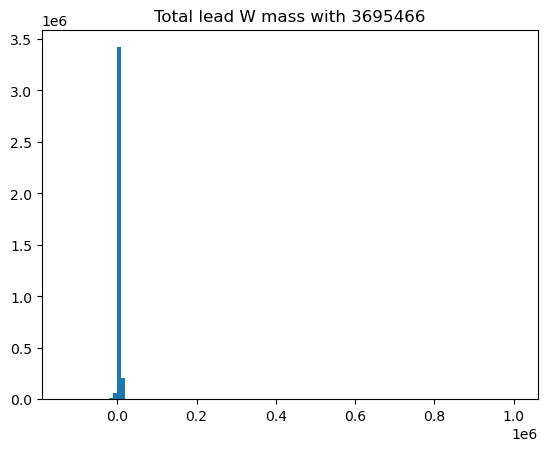

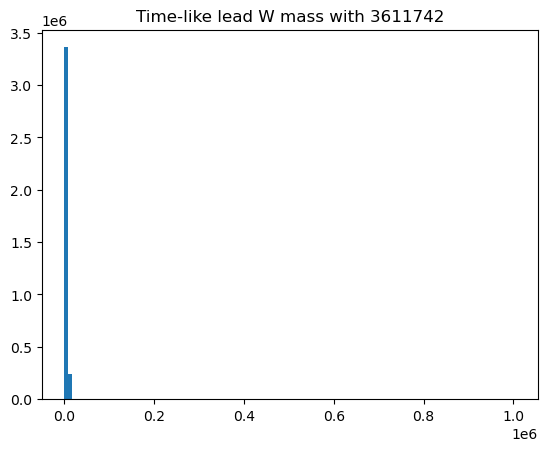

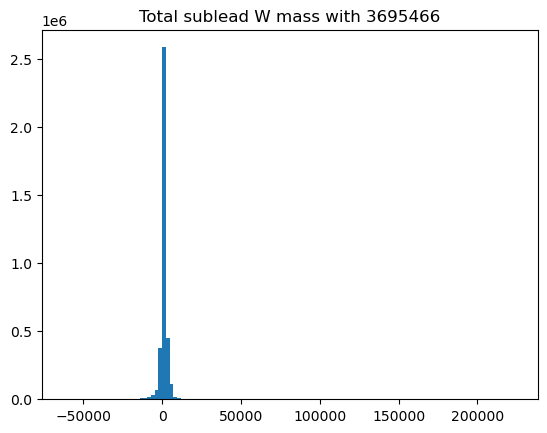

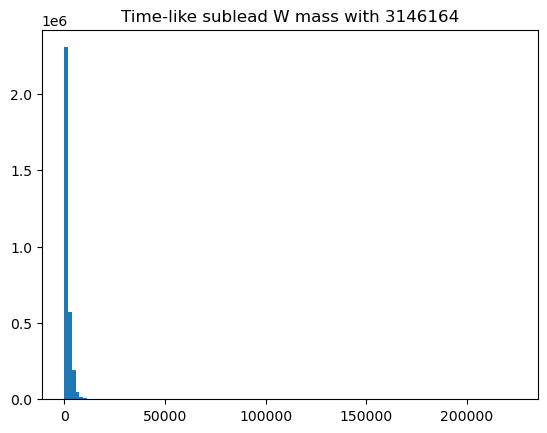

In [138]:
time_like = np.square(pred_w_lead_p4[:, 3]) - np.sum(
    np.square(pred_w_lead_p4[:, 0:-1]), axis=1
)
time_mask = time_like > 0
plt.hist(time_like, bins=120, fill=True)
plt.title(f"Total lead W mass with {len(time_like)}")
plt.show()
plt.hist(time_like[time_mask], bins=120, fill=True)
plt.title(f"Time-like lead W mass with {len(time_like[time_mask])}")
plt.show()

sub_time_like = np.square(pred_w_sublead_p4[:, 3]) - np.sum(
    np.square(pred_w_sublead_p4[:, 0:-1]), axis=1
)
sub_time_mask = sub_time_like > 0
plt.hist(sub_time_like, bins=120, fill=True)
plt.title(f"Total sublead W mass with {len(sub_time_like)}")
plt.show()
plt.hist(sub_time_like[sub_time_mask], bins=120, fill=True)
plt.title(f"Time-like sublead W mass with {len(sub_time_like[sub_time_mask])}")
plt.show()

In [163]:
# raw Ws
raw_w_lead_p4 = w_lead.p4[PRE_CUT]
raw_w_sublead_p4 = w_sublead.p4[PRE_CUT]

In [164]:
def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 4.1 test: which lepton nan when boost to W+ and W- frame
    if np.isnan(WpLp_k.Mag()) or np.isnan(WnLp_k.Mag()):
        nan_test = 1
    else:
        nan_test = 0

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
        np.array([nan_test, nan_test, nan_test]),
    )

In [165]:
def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    nan_test = np.zeros((particles.shape[0], 3))
    # bunch them together
    result = np.array((particles.shape[0], 3, 6))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(Bij, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    nan_test = np.sum(result[:, 5], axis=1) != 0
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
        nan_test,
    )

In [166]:
# reco
particles = np.concatenate(
    [
        pred_w_lead_p4,
        GEV * lead_lep.p4[PRE_CUT],
        pred_w_sublead_p4,
        GEV * sublead_lep.p4[PRE_CUT],
    ],
    axis=1,
)
(
    bij_cleaned,
    xi_lead_cleaned,
    xi_sublead_cleaned,
    ggm_lead_cleaned,
    ggm_sublead_cleaned,
    mask,
    nan_test,
) = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(mask == nan_test))

# raw
particles = np.concatenate(
    [
        raw_w_lead_p4,
        GEV * lead_lep.p4[PRE_CUT],
        raw_w_sublead_p4,
        GEV * sublead_lep.p4[PRE_CUT],
    ],
    axis=1,
)
bij, xi_lead, xi_sublead, ggm_lead, ggm_sublead, mask_raw, nan_test_raw = (
    result_generator(particles)
)
# check boost-nan and bij-nan
print(np.all(mask_raw == nan_test_raw))

True
True


In [167]:
def test(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()

    return WpLepton, WnLepton


def test_generator(particles):

    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(test, particles)))

    return result

In [168]:
# def ci(data):
#     res = stats.bootstrap(
#         (data,),
#         statistic=np.mean,
#         confidence_level=0.95,
#         n_resamples=1_024,
#         vectorized=True,
#         alternative="two-sided",
#         method="BCa",
#         random_state=RNG,
#         batch=16_384,
#     )
#     return res.confidence_interval

In [169]:
# with multiprocessing.Pool(WORKERS) as pool:
#     reco_ci = pool.map(ci, bij_cleaned.T)
#     reco_ci_xy_low, reco_ci_xy_high = reco_ci[0][0], reco_ci[0][1]
#     reco_ci_yz_low, reco_ci_yz_high = reco_ci[1][0], reco_ci[1][1]
#     reco_ci_zx_low, reco_ci_zx_high = reco_ci[2][0], reco_ci[2][1]
# print(
#     f"""
# <RECO>: EVT_NUM: {len(bij_cleaned)}
# Bxy: mean = {bij_cleaned[:, 0].mean():<.3f} with 95%CI: -{bij_cleaned[:, 0].mean() - reco_ci_xy_low:<.3f}; +{reco_ci_xy_high - bij_cleaned[:, 0].mean():<.3f}
# Byz: mean = {bij_cleaned[:, 1].mean():<.3f} with 95%CI: -{bij_cleaned[:, 1].mean() - reco_ci_yz_low:<.3f}; +{reco_ci_yz_high - bij_cleaned[:, 1].mean():<.3f}
# Bzx: mean = {bij_cleaned[:, 2].mean():<.3f} with 95%CI: -{bij_cleaned[:, 2].mean() - reco_ci_zx_low:<.3f}; +{reco_ci_zx_high - bij_cleaned[:, 2].mean():<.3f}"""
# )

# truth_Bij = pd.read_hdf(path, "truth_Bij")
# truth_Bij = truth_Bij.to_numpy()
# with multiprocessing.Pool(WORKERS) as pool:
#     truth_ci = pool.map(ci, truth_Bij.T)
#     truth_ci_xy_low, truth_ci_xy_high = truth_ci[0][0], truth_ci[0][1]
#     truth_ci_yz_low, truth_ci_yz_high = truth_ci[1][0], truth_ci[1][1]
#     truth_ci_zx_low, truth_ci_zx_high = truth_ci[2][0], truth_ci[2][1]
# print(
#     f"""
# <TRUTH>: EVT_NUM: {len(truth_Bij)}
# Bxy: mean = {truth_Bij[:, 0].mean():<.3f} with 95%CI: -{truth_Bij[:, 0].mean() - truth_ci_xy_low:<.3f}; +{truth_ci_xy_high - truth_Bij[:, 0].mean():<.3f}
# Byz: mean = {truth_Bij[:, 1].mean():<.3f} with 95%CI: -{truth_Bij[:, 1].mean() - truth_ci_yz_low:<.3f}; +{truth_ci_yz_high - truth_Bij[:, 1].mean():<.3f}
# Bzx: mean = {truth_Bij[:, 2].mean():<.3f} with 95%CI: -{truth_Bij[:, 2].mean() - truth_ci_zx_low:<.3f}; +{truth_ci_zx_high - truth_Bij[:, 2].mean():<.3f}"""
# )

In [170]:
# leading
# reco
w_lead_pt = pt(pred_w_lead_px, pred_w_lead_py)
w_lead_eta = eta(pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz)
w_lead_phi = phi(pred_w_lead_px, pred_w_lead_py)

# raw
raw_w_lead_pt = pt(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])
raw_w_lead_eta = eta(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1], raw_w_lead_p4[:, 2])
raw_w_lead_phi = phi(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])

# subleading
# reco
w_sublead_pt = pt(pred_w_sublead_px, pred_w_sublead_py)
w_sublead_eta = eta(pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz)
w_sublead_phi = phi(pred_w_sublead_px, pred_w_sublead_py)

# raw
raw_w_sublead_pt = pt(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])
raw_w_sublead_eta = eta(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1], raw_w_sublead_p4[:, 2])
raw_w_sublead_phi = phi(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])

In [171]:
truth_Bij = data.CGLMP
truth_Xi = data.Xi

def der_org_plot(
    reco_data,
    title="Bxy",
    raw_data=truth_Bij["Bxy"],
    unit=None,
    rmse=False,
    density=True,
):
    min_data = np.min([np.min(reco_data), np.min(raw_data)])
    max_data = np.max([np.max(reco_data), np.max(raw_data)])
    bin_edges = np.linspace(min_data, max_data, 81)
    plt.figure(figsize=(7, 5), dpi=100)
    hist = plt.hist(
        reco_data,
        density=density,
        bins=bin_edges,
        color="r",
        histtype="step",
        alpha=1,
        label="Reco",
    )
    if raw_data is not None:
        hist = plt.hist(
            raw_data,
            density=density,
            bins=bin_edges,
            color="grey",
            alpha=0.2,
            fill=True,
            label="label",
        )
    if unit is None:
        plt.xlabel("Null", fontsize=12)
    else:
        plt.xlabel(unit, fontsize=12)
    plt.ylabel("Norm. Count", fontsize=12)
    if rmse is True:
        plt.title(
            title
            + f" with RMSE: {np.sqrt(mean_squared_error(truth_data, reco_data)):.3f}",
            fontsize=16,
        )
    else:
        plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

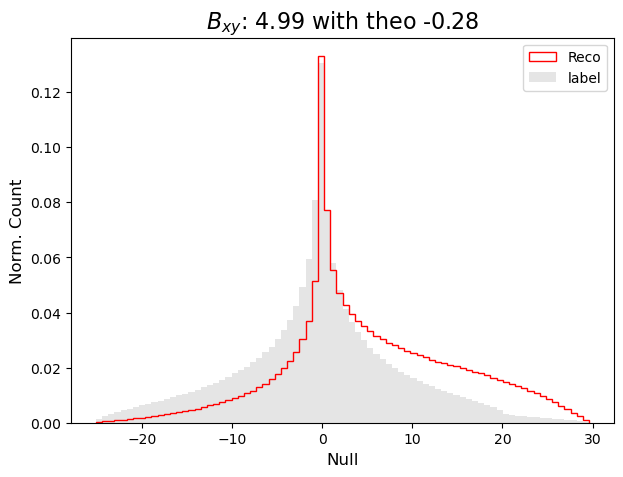

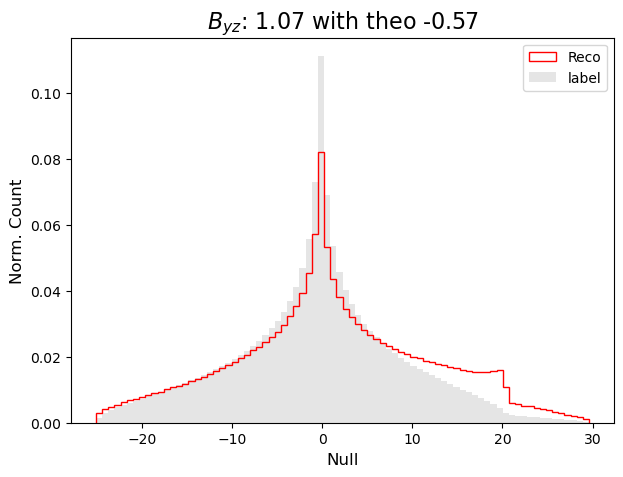

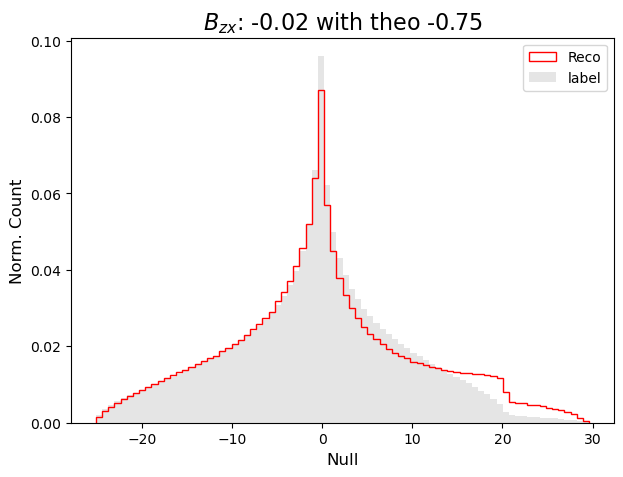

In [172]:
der_org_plot(bij_cleaned[:, 0], r"$B_{xy}$: " + f"{np.mean(bij_cleaned[:, 0]):<.2f} with theo {np.mean(truth_Bij['Bxy']):<.2f}", truth_Bij["Bxy"], rmse=False)
der_org_plot(bij_cleaned[:, 1], r"$B_{yz}$: " + f"{np.mean(bij_cleaned[:, 1]):<.2f} with theo {np.mean(truth_Bij['Byz']):<.2f}", truth_Bij["Byz"], rmse=False)
der_org_plot(bij_cleaned[:, 2], r"$B_{zx}$: " + f"{np.mean(bij_cleaned[:, 2]):<.2f} with theo {np.mean(truth_Bij['Bzx']):<.2f}", truth_Bij["Bzx"], rmse=False)

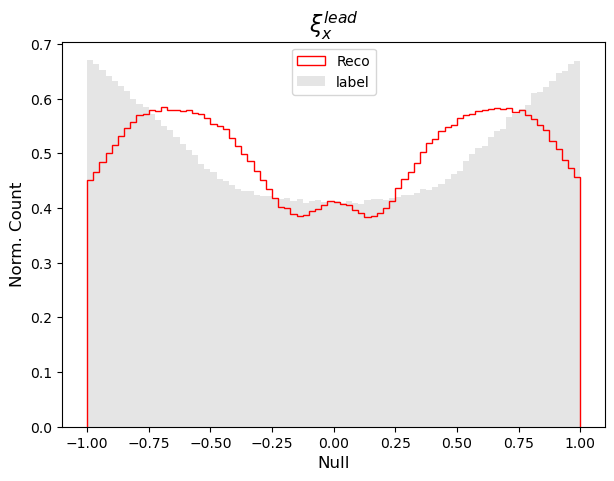

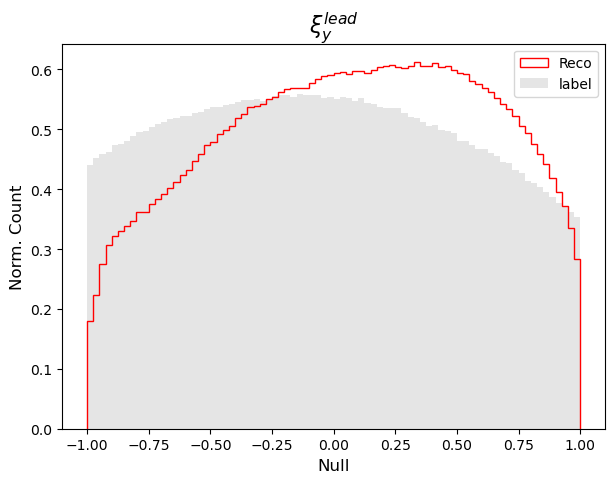

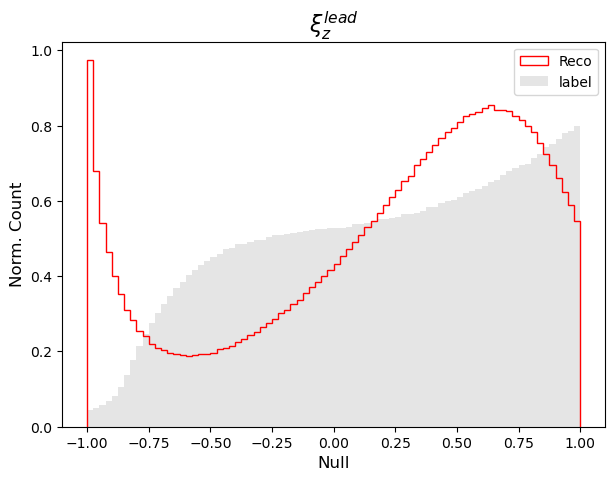

In [173]:
der_org_plot(xi_lead_cleaned[:, 0], r"$\xi^{lead}_{x}$", raw_data=xi_lead[:, 0])
der_org_plot(xi_lead_cleaned[:, 1], r"$\xi^{lead}_{y}$", raw_data=xi_lead[:, 1])
der_org_plot(xi_lead_cleaned[:, 2], r"$\xi^{lead}_{z}$", raw_data=xi_lead[:, 2])

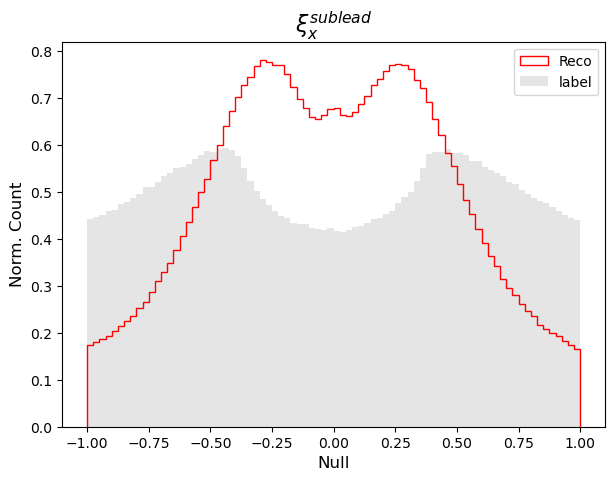

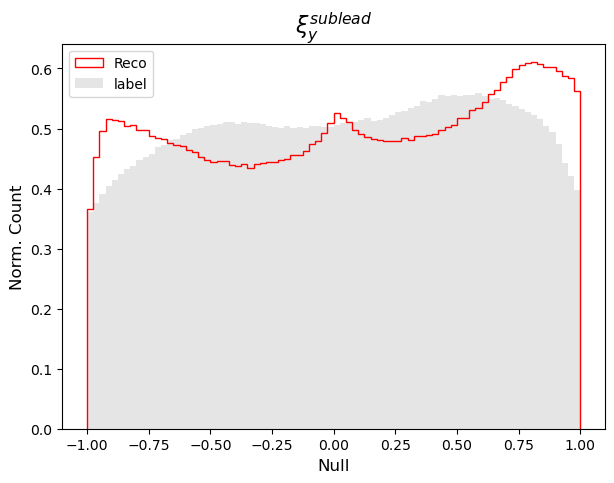

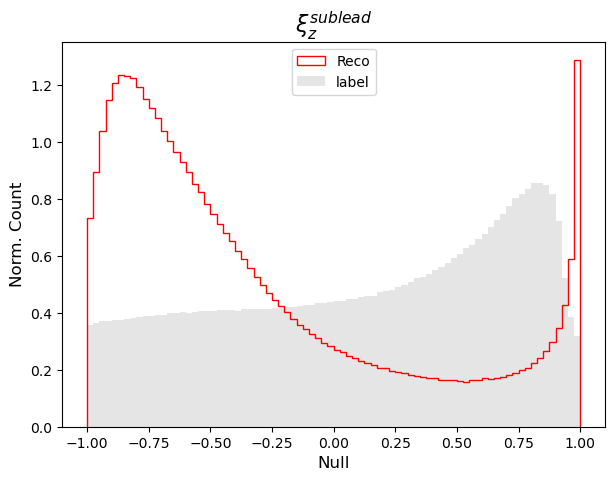

In [174]:
der_org_plot(xi_sublead_cleaned[:, 0], r"$\xi^{sublead}_{x}$", raw_data=xi_sublead[:, 0])
der_org_plot(xi_sublead_cleaned[:, 1], r"$\xi^{sublead}_{y}$", raw_data=xi_sublead[:, 1])
der_org_plot(xi_sublead_cleaned[:, 2], r"$\xi^{sublead}_{z}$", raw_data=xi_sublead[:, 2])

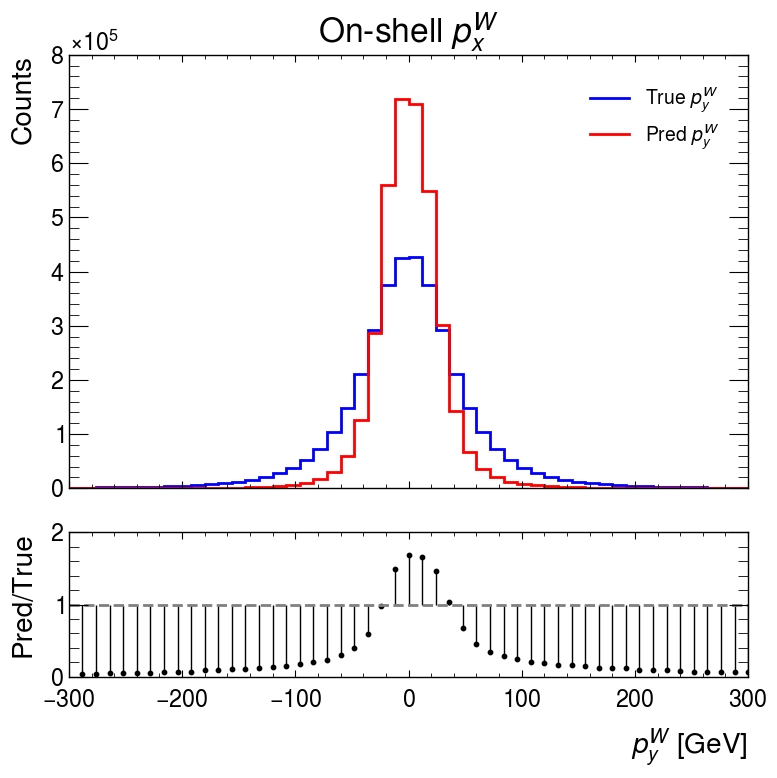

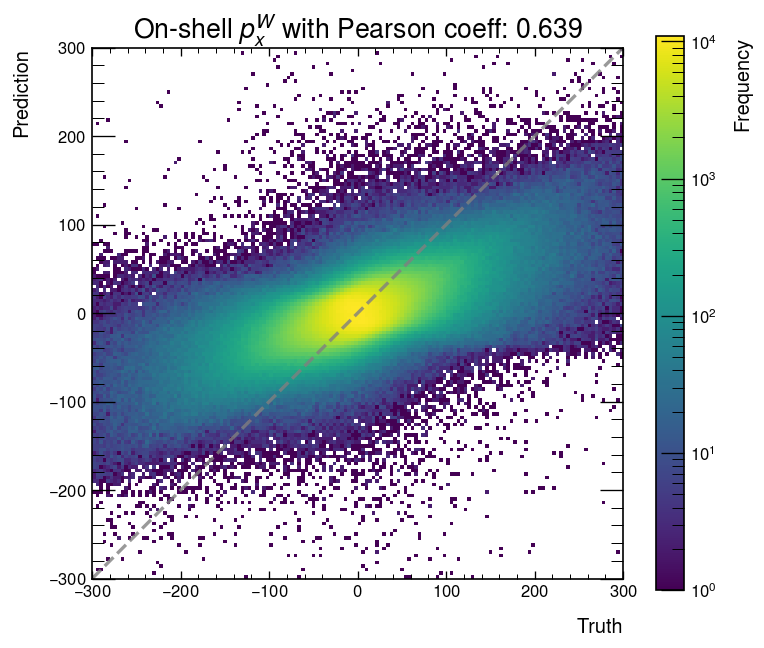

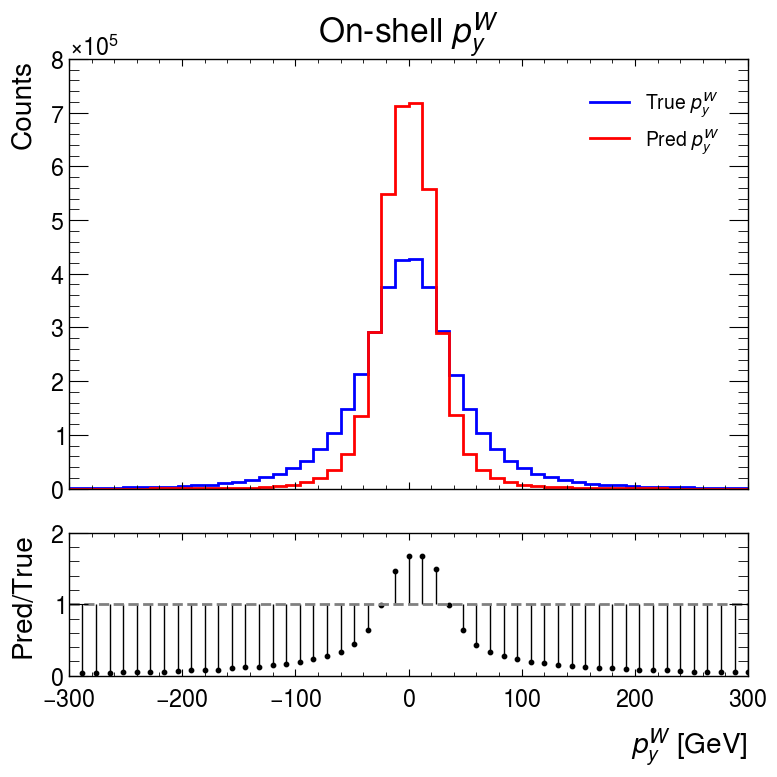

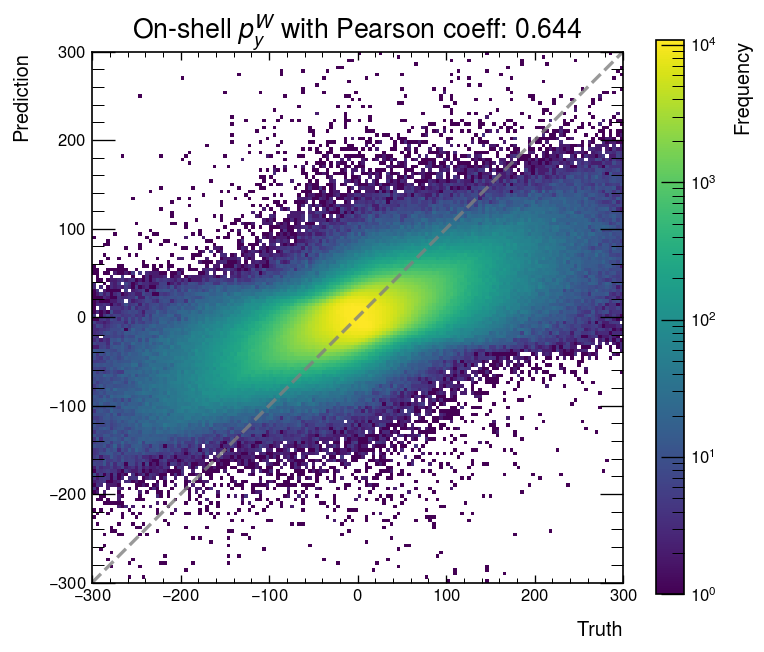

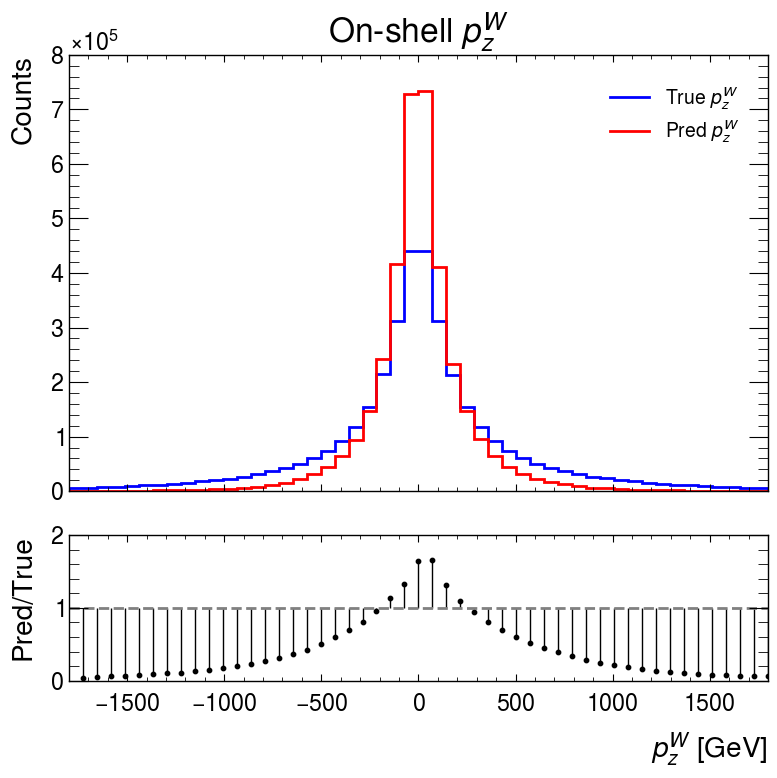

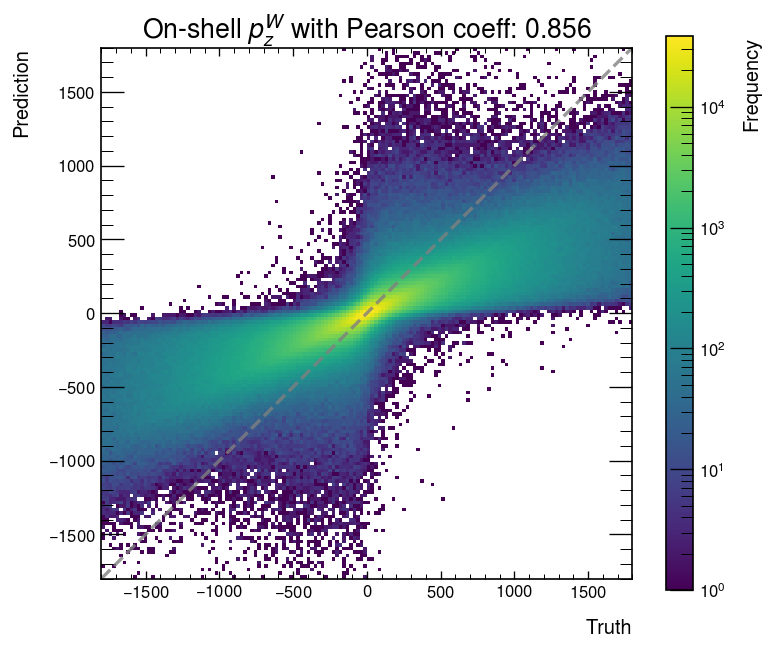

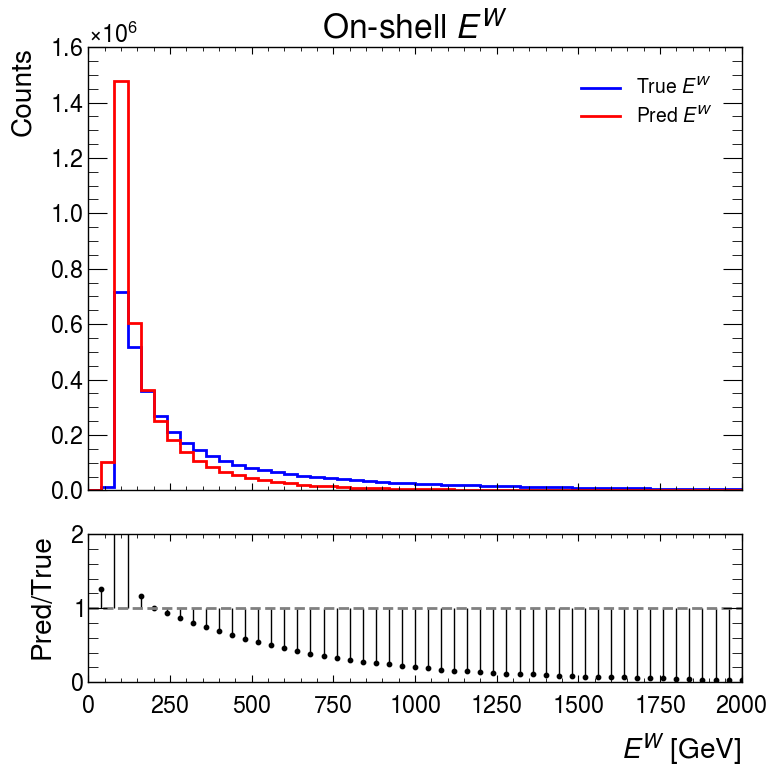

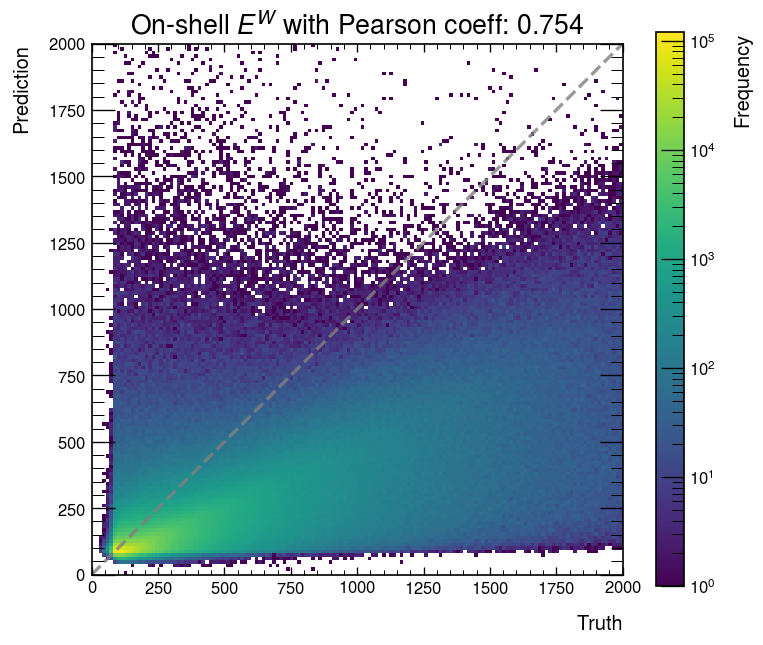

In [187]:
import scipy as sp
import atlas_plot as ap
plot = ap.Plotter()

# px
set_range = [-300, 300]
plot.hist(
    data=[raw_w_lead_p4[:, 0], pred_w_lead_px],
    label=r"$p_{y}^{W}$",
    title="On-shell $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_lead_p4[:, 0],
    pred_w_lead_px,
    r"On-shell $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_lead_p4[:, 0], pred_w_lead_px)[0]:.3f}",
    range=set_range,
)

# py
set_range = [-300, 300]
plot.hist(
    data=[raw_w_lead_p4[:, 1], pred_w_lead_py],
    label=r"$p_{y}^{W}$",
    title="On-shell $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_lead_p4[:, 1],
    pred_w_lead_py,
    r"On-shell $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_lead_p4[:, 1], pred_w_lead_py)[0]:.3f}",
    range=set_range,
)

# pz
set_range = [-1800, 1800]
plot.hist(
    data=[raw_w_lead_p4[:, 2], pred_w_lead_pz],
    label=r"$p_{z}^{W}$",
    title="On-shell $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_lead_p4[:, 2],
    pred_w_lead_pz,
    r"On-shell $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_lead_p4[:, 2], pred_w_lead_pz)[0]:.3f}",
    range=set_range,
)

# energy
set_range = [0, 2000]
plot.hist(
    data=[raw_w_lead_p4[:, 3], pred_w_lead_energy],
    label=r"$E^{W}$",
    title="On-shell $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_lead_p4[:, 3],
    pred_w_lead_energy,
    r"On-shell $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_lead_p4[:, 3], pred_w_lead_energy)[0]:.3f}",
    range=set_range,
)

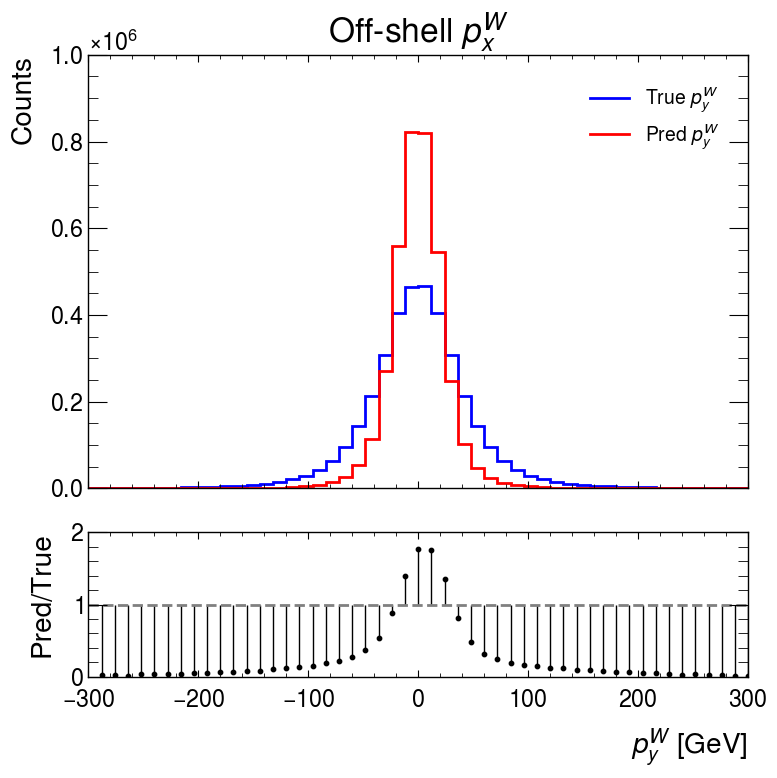

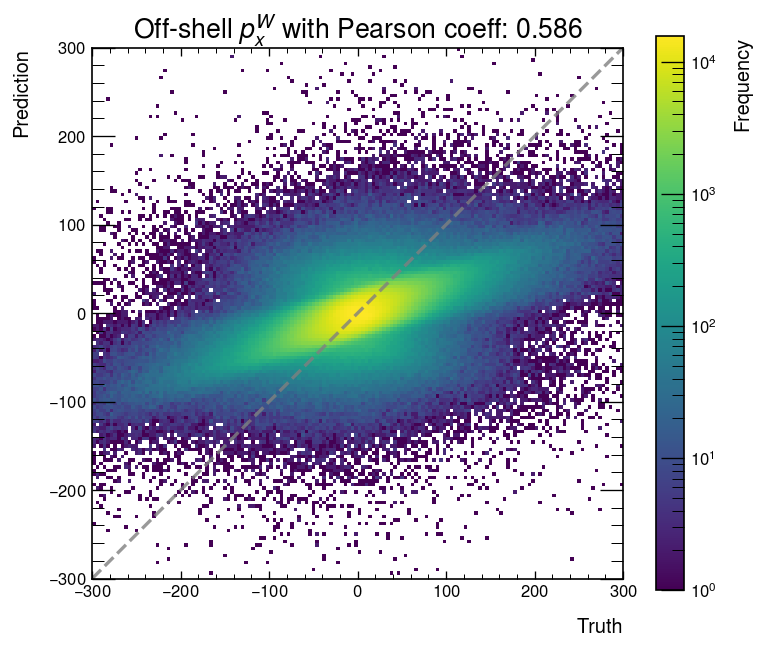

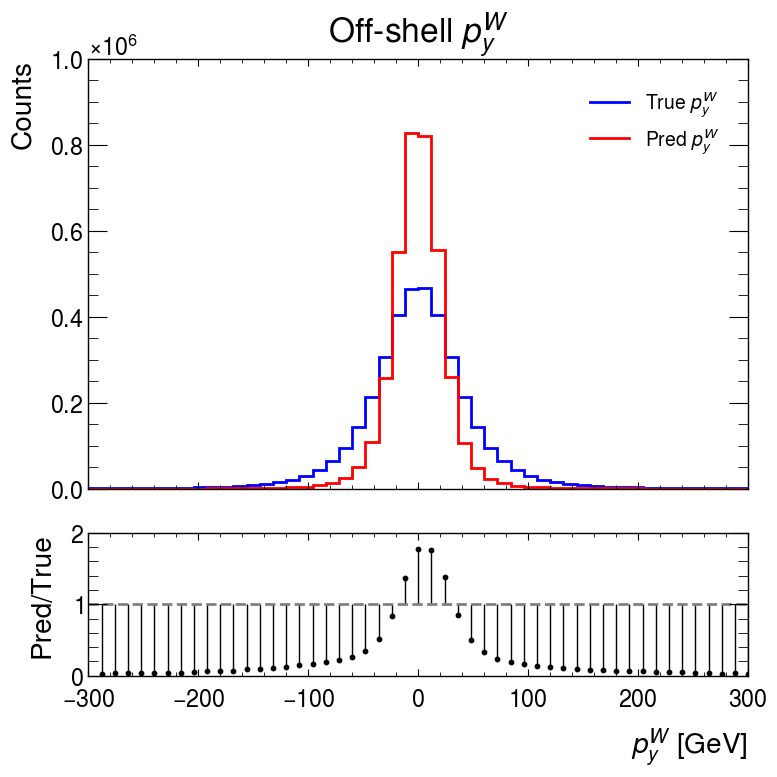

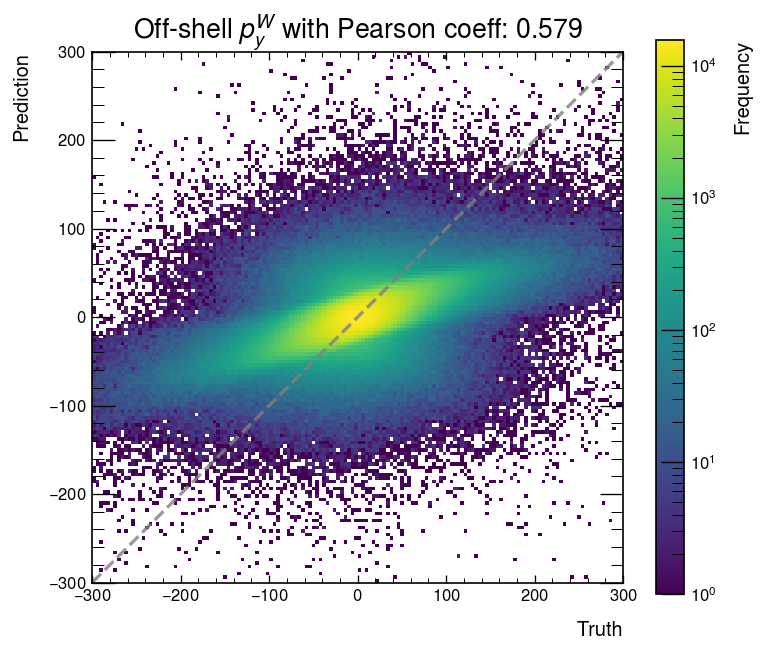

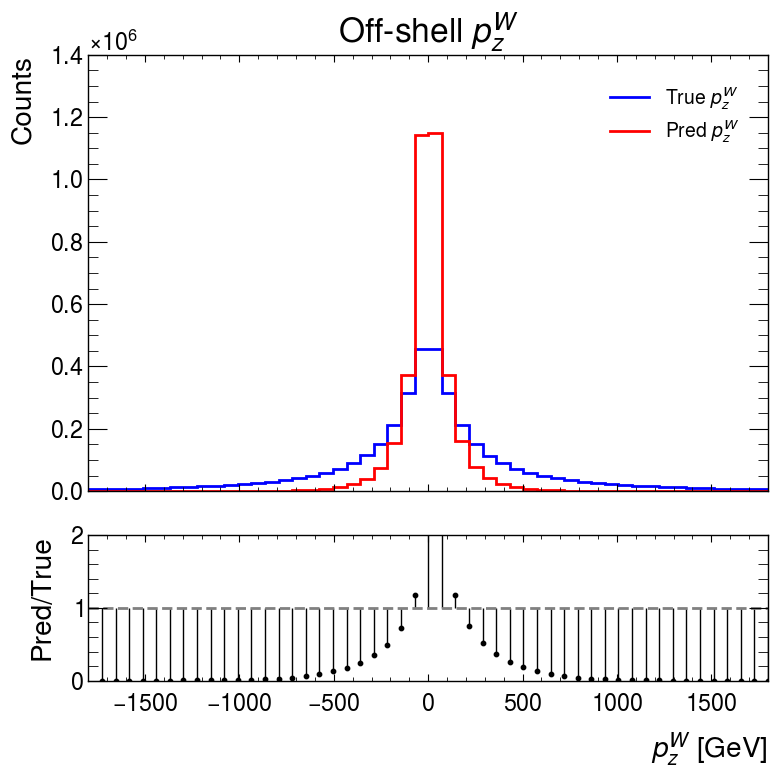

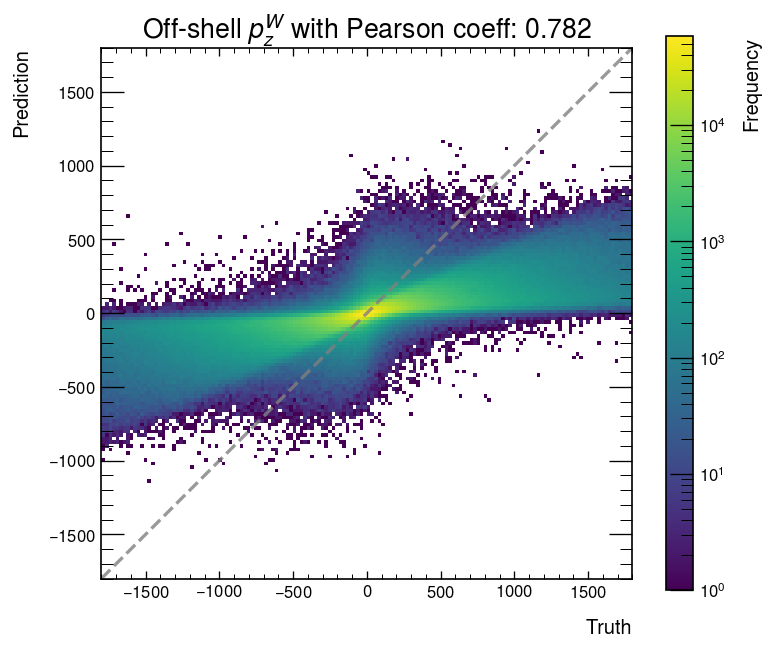

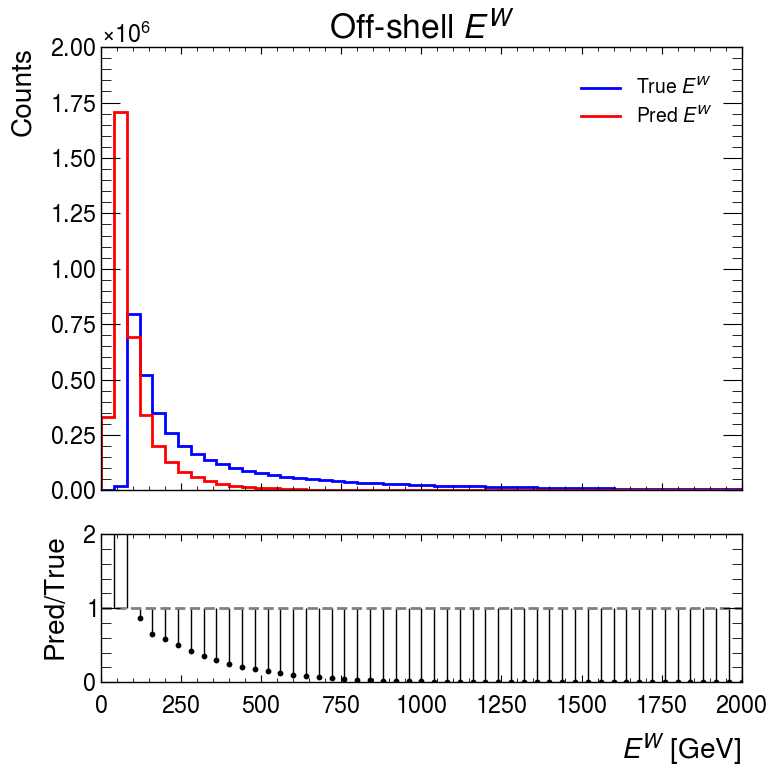

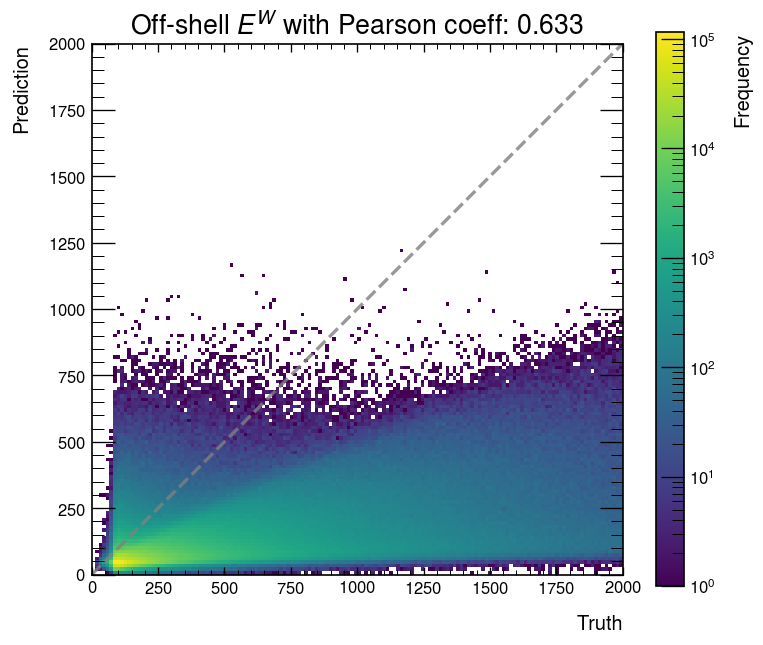

In [188]:
# px
set_range = [-300, 300]
plot.hist(
    data=[raw_w_sublead_p4[:, 0], pred_w_sublead_px],
    label=r"$p_{y}^{W}$",
    title="Off-shell $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_sublead_p4[:, 0],
    pred_w_sublead_px,
    r"Off-shell $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_sublead_p4[:, 0], pred_w_sublead_px)[0]:.3f}",
    range=set_range,
)

# py
set_range = [-300, 300]
plot.hist(
    data=[raw_w_sublead_p4[:, 1], pred_w_sublead_py],
    label=r"$p_{y}^{W}$",
    title="Off-shell $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_sublead_p4[:, 1],
    pred_w_sublead_py,
    r"Off-shell $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_sublead_p4[:, 1], pred_w_sublead_py)[0]:.3f}",
    range=set_range,
)

# pz
set_range = [-1800, 1800]
plot.hist(
    data=[raw_w_sublead_p4[:, 2], pred_w_sublead_pz],
    label=r"$p_{z}^{W}$",
    title="Off-shell $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_sublead_p4[:, 2],
    pred_w_sublead_pz,
    r"Off-shell $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_sublead_p4[:, 2], pred_w_sublead_pz)[0]:.3f}",
    range=set_range,
)

# energy
set_range = [0, 2000]
plot.hist(
    data=[raw_w_sublead_p4[:, 3], pred_w_sublead_energy],
    label=r"$E^{W}$",
    title="Off-shell $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)
plot.plot_2d_histogram(
    raw_w_sublead_p4[:, 3],
    pred_w_sublead_energy,
    r"Off-shell $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(raw_w_sublead_p4[:, 3], pred_w_sublead_energy)[0]:.3f}",
    range=set_range,
)

In [189]:
# # lead
# der_org_plot(
#     pred_w_lead_px,
#     r"$p_{x}^{lead}$",
#     raw_data=raw_w_lead_p4[:, 0],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_lead_py,
#     r"$p_{y}^{lead}$",
#     raw_data=raw_w_lead_p4[:, 1],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_lead_pz,
#     r"$p_{z}^{lead}$",
#     raw_data=raw_w_lead_p4[:, 2],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_lead_energy,
#     r"$E^{lead}$",
#     raw_data=raw_w_lead_p4[:, 3],
#     rmse=False,
# )
# # sublead
# der_org_plot(
#     pred_w_sublead_px,
#     r"$p_{x}^{sublead}$",
#     raw_data=raw_w_sublead_p4[:, 0],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_sublead_py,
#     r"$p_{y}^{sublead}$",
#     raw_data=raw_w_sublead_p4[:, 1],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_sublead_pz,
#     r"$p_{z}^{sublead}$",
#     raw_data=raw_w_sublead_p4[:, 2],
#     rmse=False,
# )
# der_org_plot(
#     pred_w_sublead_energy,
#     r"$E^{sublead}$",
#     raw_data=raw_w_sublead_p4[:, 3],
#     rmse=False,
# )

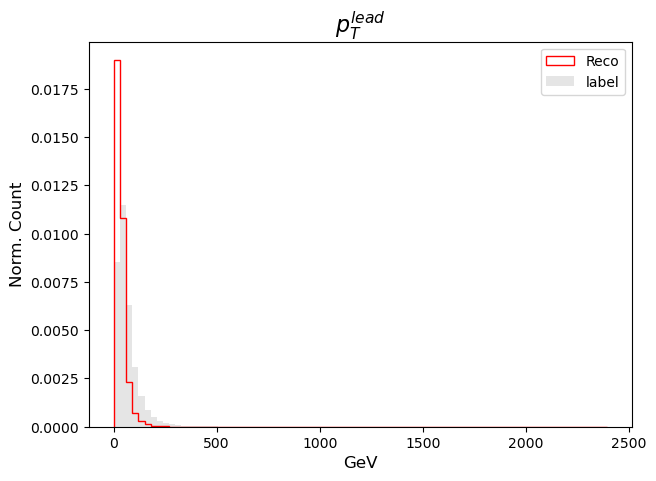

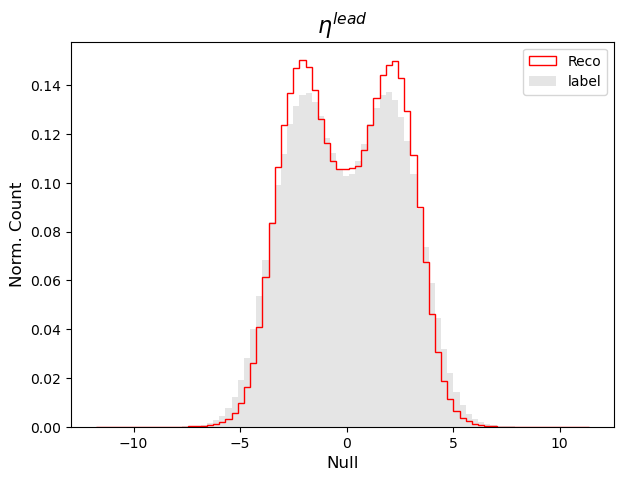

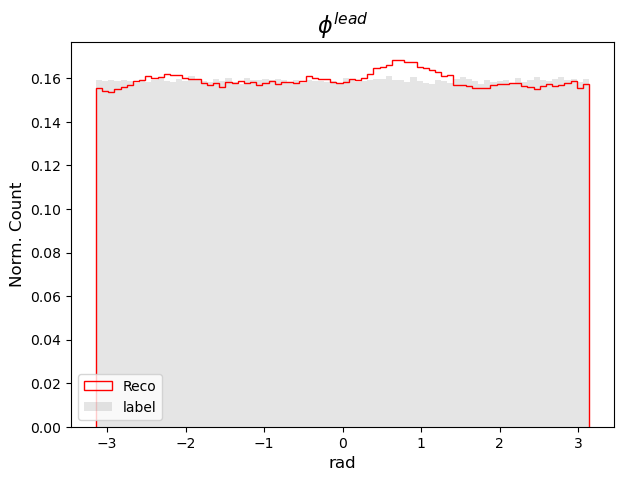

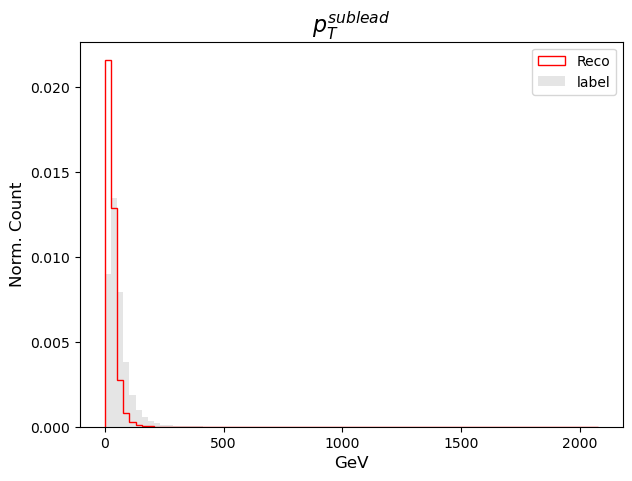

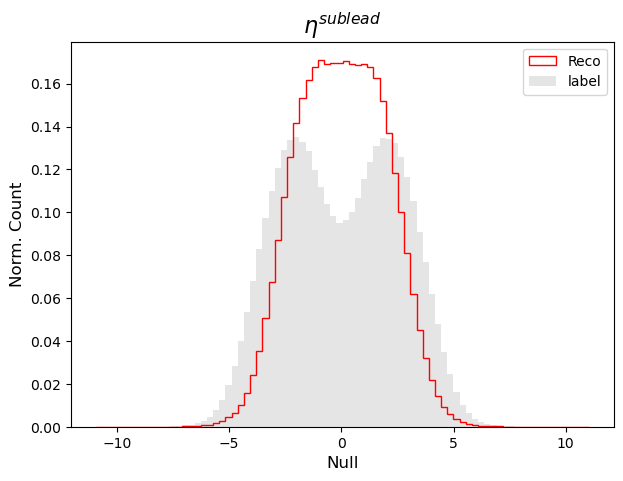

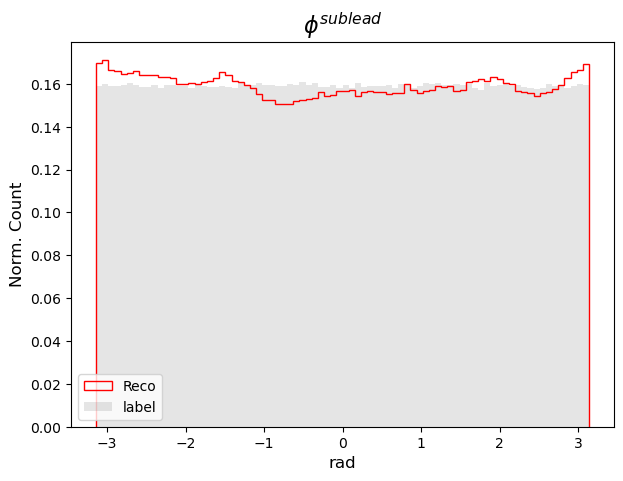

In [176]:
# leading
der_org_plot(
    w_lead_pt,
    r"$p^{lead}_{T}$",
    unit="GeV",
    raw_data=raw_w_lead_pt,
    rmse=False,
)
der_org_plot(
    w_lead_eta, r"$\eta^{lead}$", raw_data=raw_w_lead_eta, rmse=False
)
der_org_plot(
    w_lead_phi,
    r"$\phi^{lead}$",
    unit="rad",
    raw_data=raw_w_lead_phi,
    rmse=False,
)
# subleading
der_org_plot(
    w_sublead_pt,
    r"$p^{sublead}_{T}$",
    unit="GeV",
    raw_data=raw_w_sublead_pt,
    rmse=False,
)
der_org_plot(
    w_sublead_eta,
    r"$\eta^{sublead}$",
    raw_data=raw_w_sublead_eta,
    rmse=False,
)
der_org_plot(
    w_sublead_phi,
    r"$\phi^{sublead}$",
    unit="rad",
    raw_data=raw_w_sublead_phi,
    rmse=False,
)

In [177]:
def miss_plot(full_data, miss_data, title=r"$\eta_{lead}$", unit=None, density=True):
    min_data = np.min([np.min(full_data), np.min(miss_data)])
    max_data = np.max([np.max(full_data), np.max(miss_data)])
    bins_edges = np.linspace(min_data, max_data, 121)
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, full_data],
        bins=bins_edges,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()


def miss_w_plot(
    pass_data, miss_data, raw_data, title=r"$\eta_{lead}$", unit=None, density=True
):
    min_data = np.min([np.min(pass_data), np.min(miss_data), np.min(raw_data)])
    max_data = np.max([np.max(pass_data), np.max(miss_data), np.max(raw_data)])
    bins_edges = np.linspace(min_data, max_data, 121)
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, pass_data],
        bins=bins_edges,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    plt.hist(
        raw_data,
        bins=bins_edges,
        density=density,
        alpha=1.0,
        label="label",
        histtype="step",
        stacked=False,
        color="grey",
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

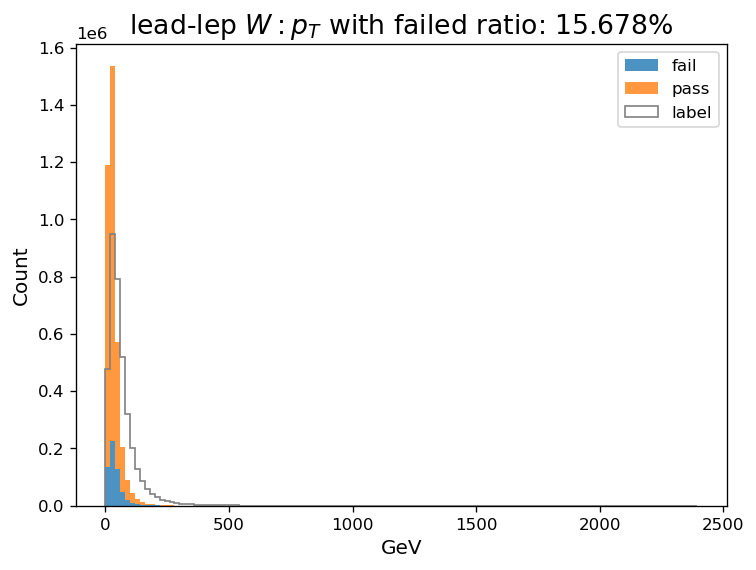

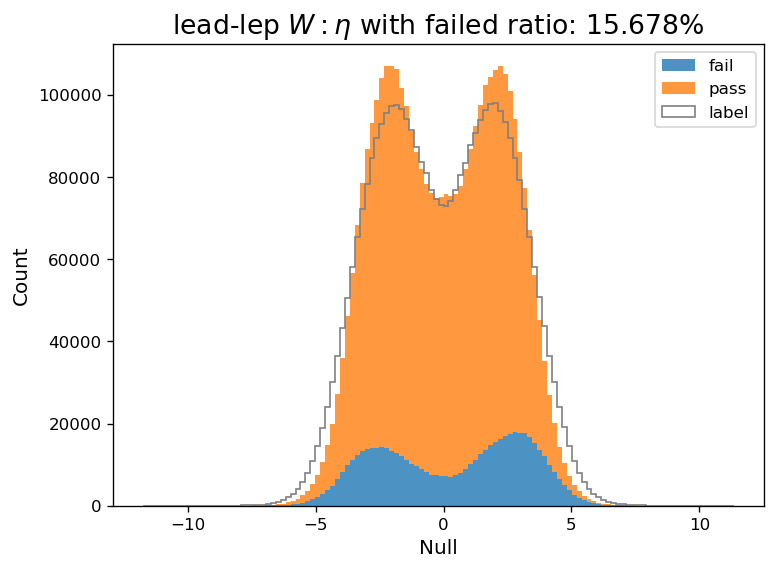

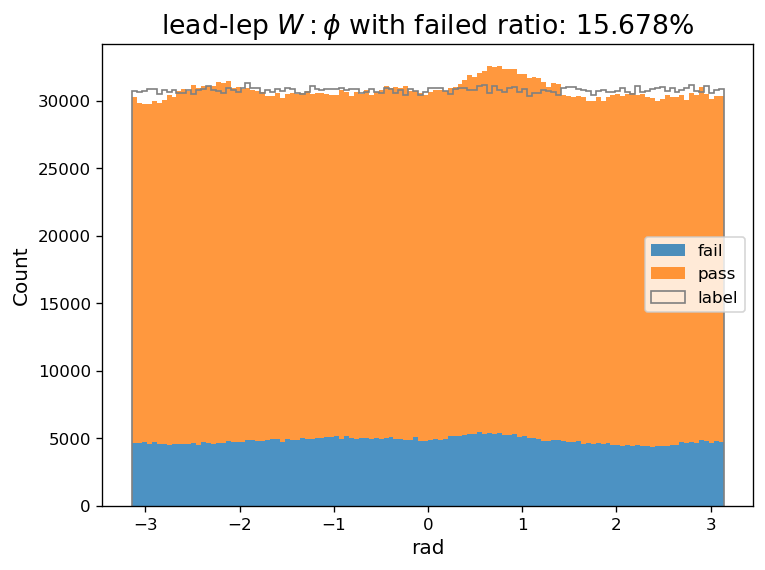

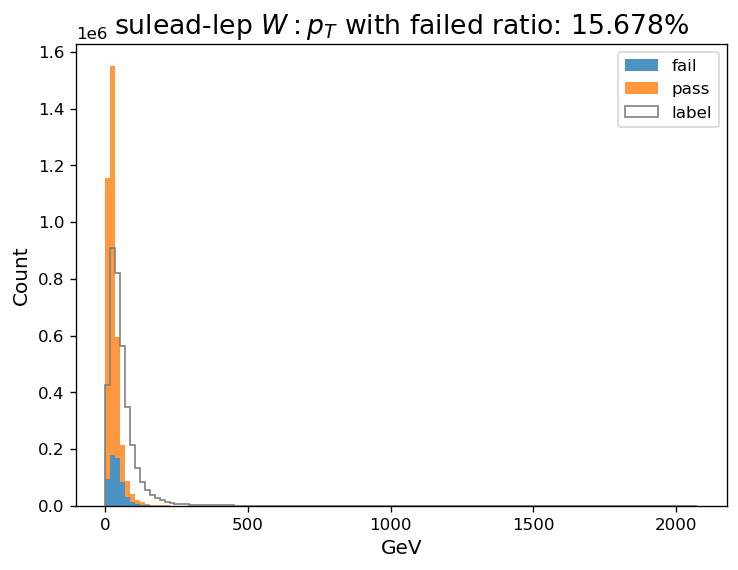

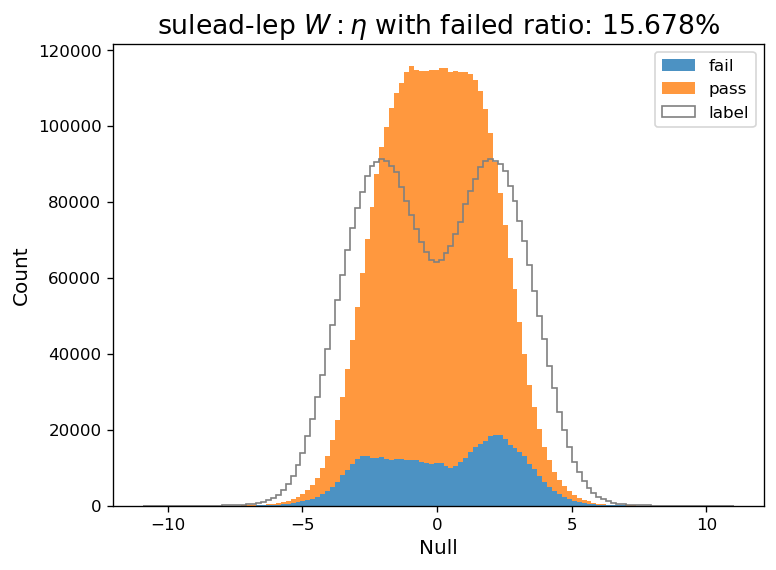

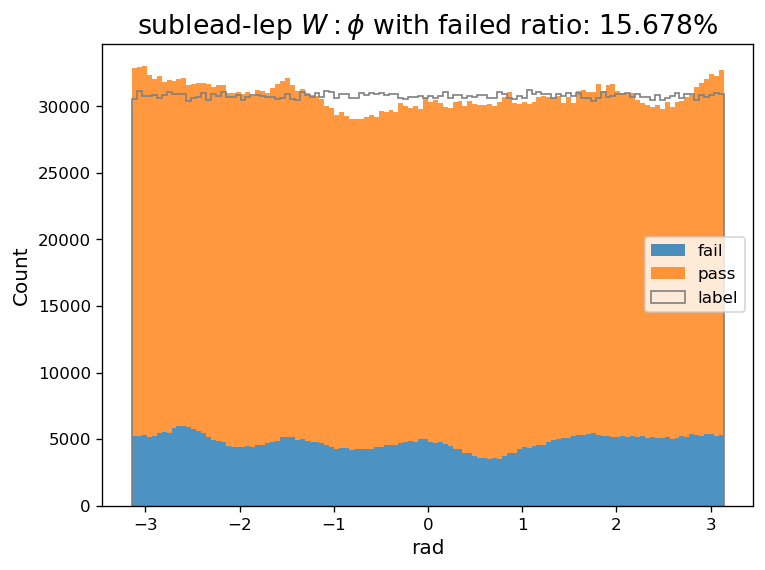

In [178]:
# lead
miss_w_plot(
    w_lead_pt[~mask],
    w_lead_pt[mask],
    raw_w_lead_pt,
    r"lead-lep $W: p_{T}$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_lead_eta[~mask],
    w_lead_eta[mask],
    raw_w_lead_eta,
    r"lead-lep $W: \eta$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_lead_phi[~mask],
    w_lead_phi[mask],
    raw_w_lead_phi,
    r"lead-lep $W: \phi$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="rad",
    density=False,
)

# sublead
miss_w_plot(
    w_sublead_pt[~mask],
    w_sublead_pt[mask],
    raw_w_sublead_pt,
    r"sulead-lep $W: p_{T}$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_sublead_eta[~mask],
    w_sublead_eta[mask],
    raw_w_sublead_eta,
    r"sulead-lep $W: \eta$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_sublead_phi[~mask],
    w_sublead_phi[mask],
    raw_w_sublead_phi,
    r"sublead-lep $W: \phi$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="rad",
    density=False,
)

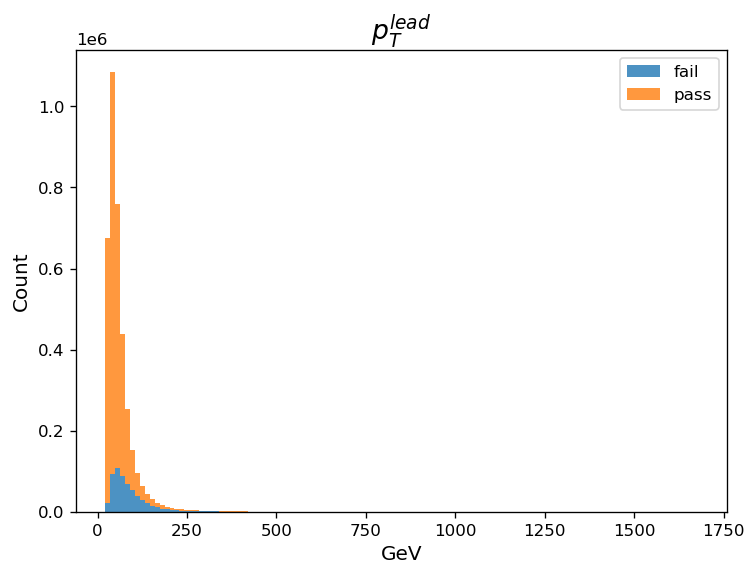

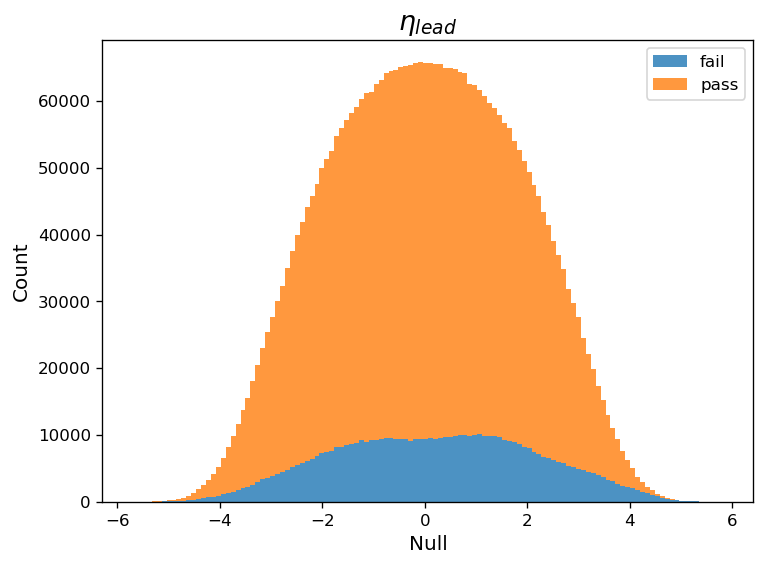

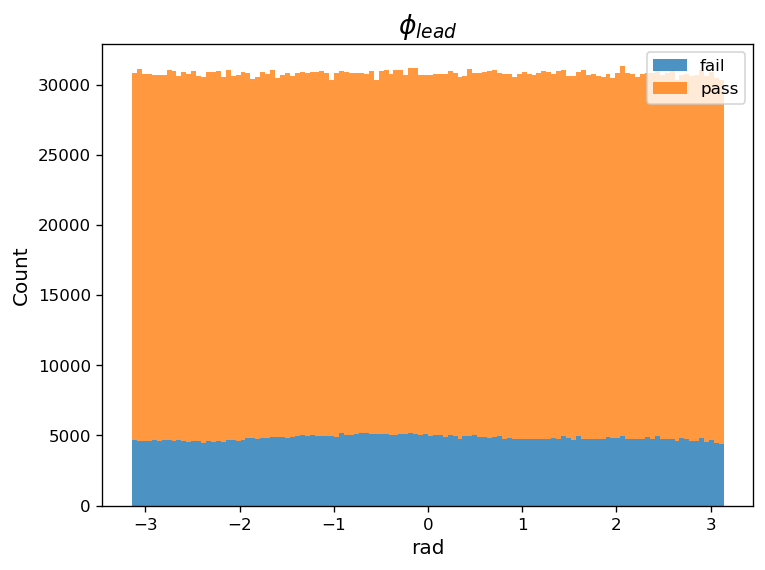

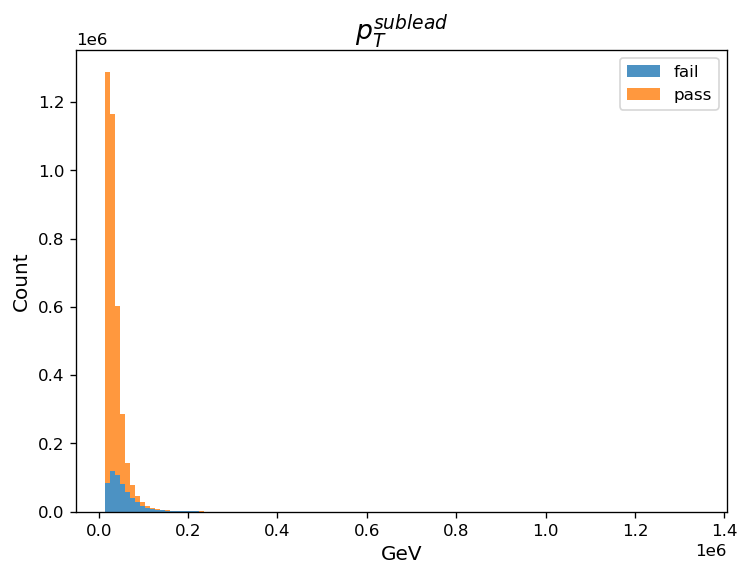

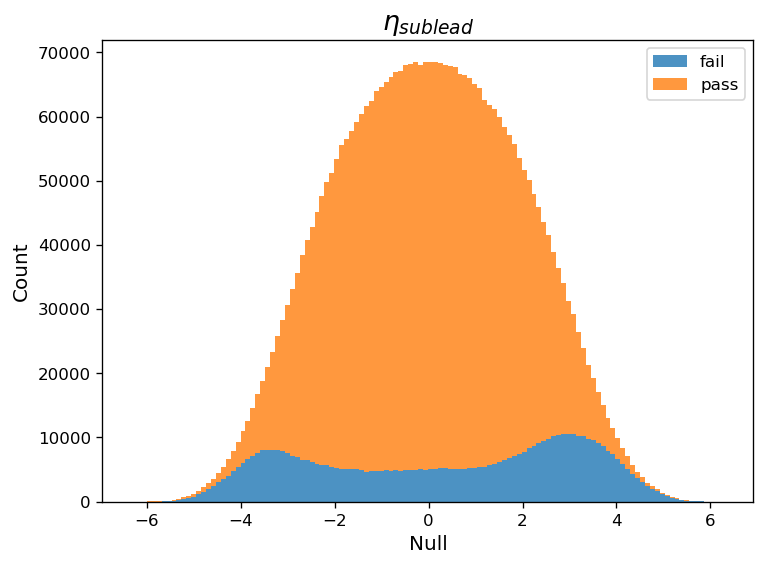

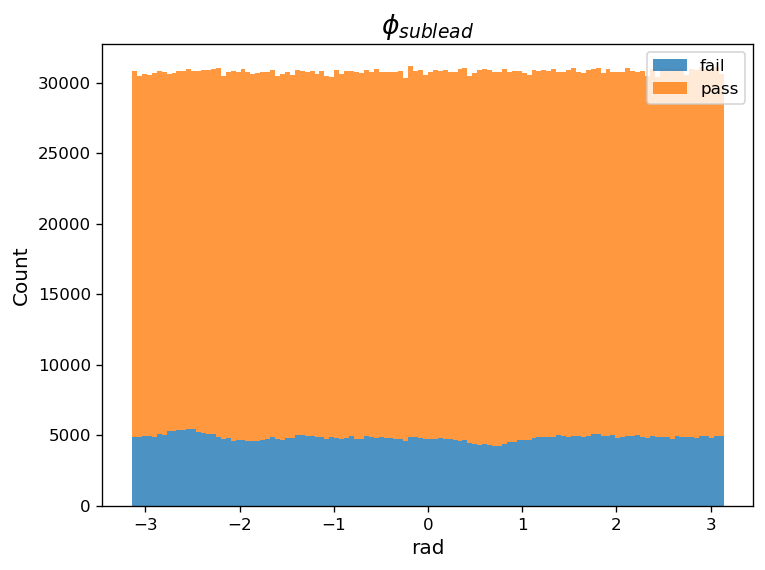

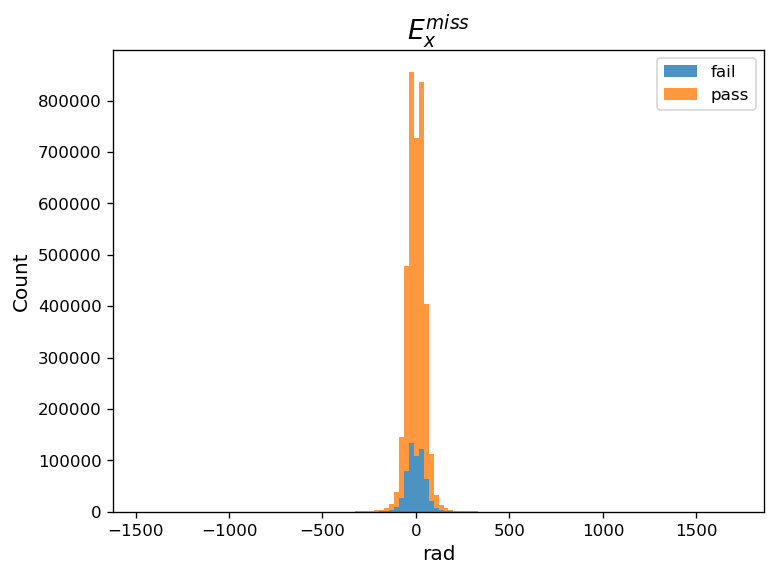

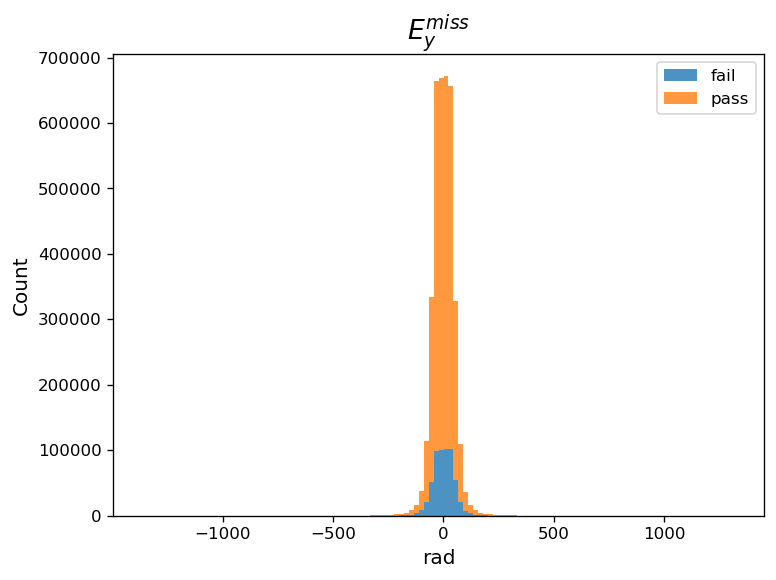

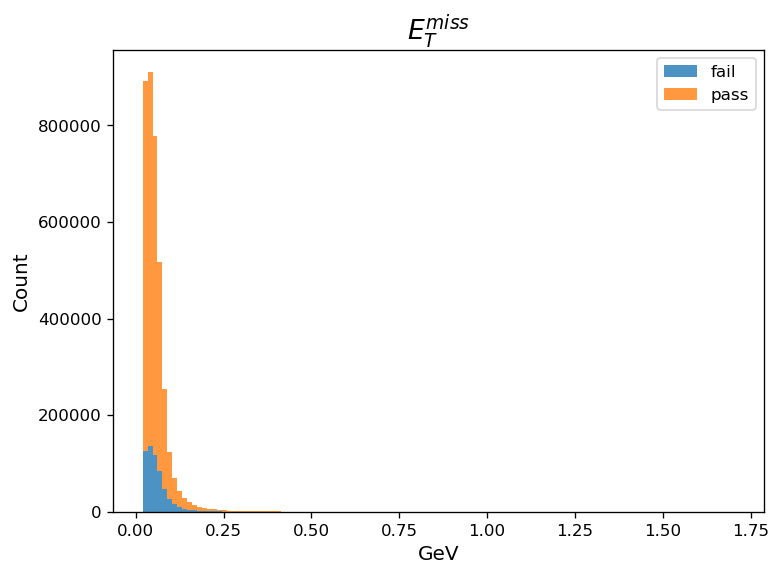

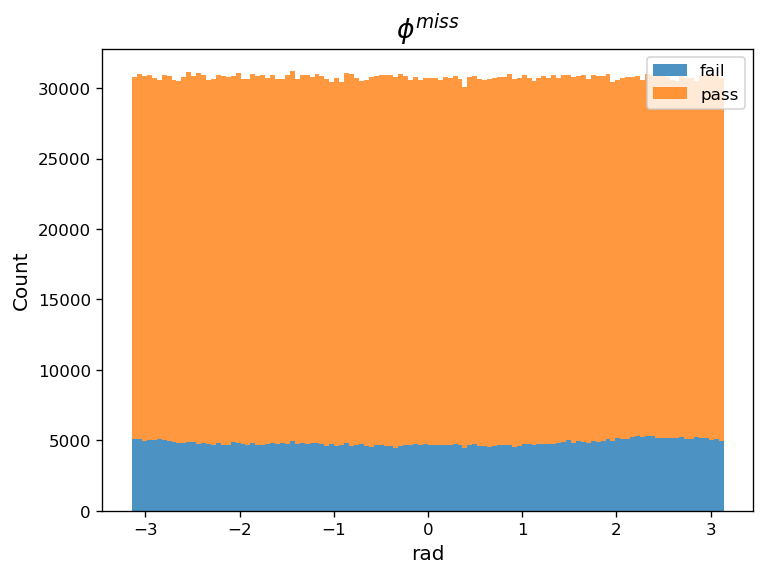

In [179]:
# lead
miss_plot(
    lead_lep.pt[PRE_CUT][~mask], lead_lep.pt[PRE_CUT][mask], r"$p_{T}^{lead}$", unit="GeV", density=False
)
miss_plot(lead_lep.eta[PRE_CUT][~mask], lead_lep.eta[PRE_CUT][mask], r"$\eta_{lead}$", density=False)
miss_plot(
    lead_lep.phi[PRE_CUT][~mask], lead_lep.phi[PRE_CUT][mask], r"$\phi_{lead}$", unit="rad", density=False
)
# sublead
miss_plot(
    sublead_lep.pt[PRE_CUT][~mask],
    sublead_lep.pt[PRE_CUT][mask],
    r"$p_{T}^{sublead}$",
    unit="GeV",
    density=False,
)
miss_plot(
    sublead_lep.eta[PRE_CUT][~mask], sublead_lep.eta[PRE_CUT][mask], r"$\eta_{sublead}$", density=False
)
miss_plot(
    sublead_lep.phi[PRE_CUT][~mask],
    sublead_lep.phi[PRE_CUT][mask],
    r"$\phi_{sublead}$",
    unit="rad",
    density=False,
)
# met
miss_plot(
    met.px[PRE_CUT][~mask],
    met.px[PRE_CUT][mask],
    r"$E^{miss}_{x}$",
    unit="rad",
    density=False,
)
miss_plot(
    met.py[PRE_CUT][~mask],
    met.py[PRE_CUT][mask],
    r"$E^{miss}_{y}$",
    unit="rad",
    density=False,
)
miss_plot(
    met.pt[PRE_CUT][~mask],
    met.pt[PRE_CUT][mask],
    r"$E^{miss}_{T}$",
    unit="GeV",
    density=False,
)
miss_plot(
    met.phi[PRE_CUT][~mask],
    met.phi[PRE_CUT][mask],
    r"$\phi^{miss}$",
    unit="rad",
    density=False,
)

In [180]:
t_end = time.time()
print(f"Total spending time: {t_end-t_start: .2f} (s)")

Total spending time:  1972.29 (s)
